<a href="https://colab.research.google.com/github/Yudishthir12/TP-2-EXAM/blob/main/hotspot_and_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


Hotspot threshold (75th percentile) =  35.0
Classification metrics: {'roc_auc': np.float64(0.9940609566543435), 'accuracy': 0.9688427026329851, 'precision': 0.9163266671125677, 'recall': 0.9688826025459689, 'f1': 0.941872056649823}
Saved precinct_month_counts.csv (contains is_hotspot labels)
Saved forecast_24_months.csv (24-month horizon)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


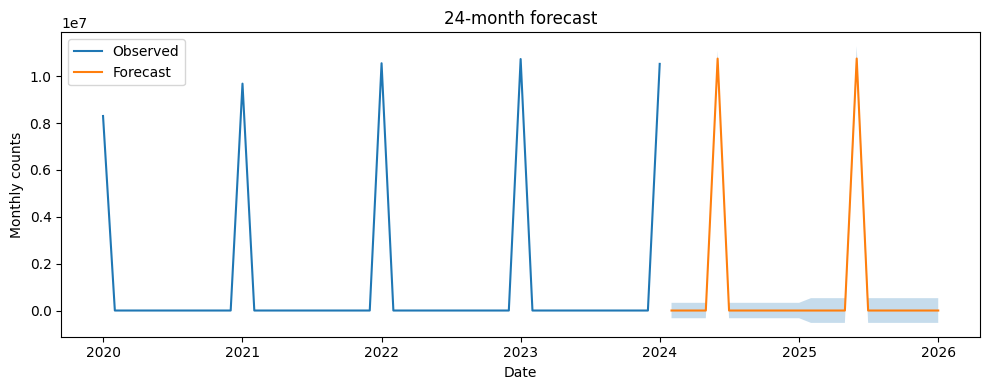

In [30]:
# --- START: preprocessing -> hotspots -> classification -> forecasting pipeline ---
# Save as crime_hotspot_forecast.py or run in a notebook cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- configuration ----------
file_paths = [
    "/content/drive/MyDrive/TP2/EXAM/2024-2025_-_1st_Quarter_WEB.xlsx",
    "/content/drive/MyDrive/TP2/EXAM/2024-2025_-_2nd_Quarter_WEB.xlsx"
]
sheet_name = "RAW Data"   # common sheet name in your files
# If your sheet header is at row X (0-indexed), set header_row = X. If unknown, set header_row=None to inspect.
header_row = 2

# ---------- helper to load sheet robustly ----------
def load_and_inspect(path, sheet_name="RAW Data", header_row=None, n_preview=20):
    # If header_row is None, read first 30 rows without header to inspect layout
    if header_row is None:
        df_preview = pd.read_excel(path, sheet_name=sheet_name, header=None, nrows=n_preview)
        print(f"\nPreview of top {n_preview} rows from {path} / sheet `{sheet_name}` (no header):")
        display(df_preview)
        raise SystemExit("Please re-run with header_row set to the 0-indexed row that contains column names.")
    else:
        df = pd.read_excel(path, sheet_name=sheet_name, header=header_row)
        # ensure string column names
        df.columns = [str(c).strip() for c in df.columns]
        return df

# ---------- load files ----------
dfs = []
for p in file_paths:
    df = load_and_inspect(p, sheet_name=sheet_name, header_row=header_row)  # if header_row=None the function will stop explaining
    dfs.append(df)

# ---------- normalize column names ----------
# Common columns we must find: date/month, precinct/station, offence/category OR a layout with one row per precinct/offence and many date columns
# For typical SAPS web excel, you might find columns like 'Station', 'Suburb', or one column per month (e.g., 'Apr 2024', 'May 2024')
def find_datetime_columns(cols):
    # heuristics: if column names look like month names or contain year numbers
    candidates = []
    for c in cols:
        cs = c.lower()
        if any(m in cs for m in ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']) or any(str(y) in cs for y in range(2000,2030)):
            candidates.append(c)
    return candidates

# Example code for two possible layouts:
# Layout A: incident-level rows with a ReportDate column
# Layout B: pivoted summary where rows are offence types and columns are months (need to melt to long format)

# ---------- when you have incident-level rows ----------
# if dataframe has a 'ReportDate' or 'Date' column:
if any(c.lower() in ['reportdate','date','occurred','reported'] for c in dfs[0].columns):
    # standard incident-level path
    dfi = pd.concat(dfs, ignore_index=True, sort=False)
    # find date col
    date_col = next(c for c in dfi.columns if c.lower() in ['reportdate','date','occurred','reported'])
    dfi['ReportDate'] = pd.to_datetime(dfi[date_col], errors='coerce', dayfirst=True)
    dfi = dfi[~dfi['ReportDate'].isna()].copy()
    dfi['year_month'] = dfi['ReportDate'].dt.to_period('M').astype(str)
    # precinct and category columns (heuristic)
    precinct_col = next((c for c in dfi.columns if 'station' in c.lower() or 'precinct' in c.lower() or 'police' in c.lower()), None)
    category_col = next((c for c in dfi.columns if 'offence' in c.lower() or 'crime' in c.lower() or 'category' in c.lower()), None)
    if precinct_col is None: dfi['precinct'] = "UNKNOWN"
    else: dfi['precinct'] = dfi[precinct_col].astype(str).str.strip().fillna('UNKNOWN')
    if category_col is None: dfi['category'] = "UNKNOWN"
    else: dfi['category'] = dfi[category_col].astype(str).str.strip().fillna('UNKNOWN')

    # precinct x month counts
    counts = dfi.groupby(['precinct','year_month']).size().reset_index(name='incident_count')
else:
    # ---------- Layout B (summary pivot): melt month columns into a long table ----------
    # This block handles when each row is a station/offence and the columns are months with values.
    # Heuristic: find columns that look like months (Apr 2024, May-2024 etc.)
    df_comb = pd.concat(dfs, ignore_index=True, sort=False)
    mcols = find_datetime_columns(df_comb.columns)
    if len(mcols) == 0:
        raise SystemExit("Could not find month-like columns automatically. Inspect the sheet and specify header_row or month columns.")
    # find precinct-like column
    precinct_col = next((c for c in df_comb.columns if 'station' in c.lower() or 'precinct' in c.lower() or 'police' in c.lower()), None)
    if precinct_col is None:
        # maybe there's a column called 'Station' but spelled differently — inspect manually
        print("Columns available:", list(df_comb.columns)[:50])
        raise SystemExit("Please identify which column contains station/precinct names and re-run.")
    # melt
    long = df_comb.melt(id_vars=[precinct_col], value_vars=mcols, var_name='year_month', value_name='incident_count')
    long['year_month'] = long['year_month'].astype(str).str.replace('.0','',regex=False)
    long['year_month_dt'] = pd.to_datetime(long['year_month'], errors='coerce', dayfirst=True)
    # fallback if parsing fails: try parse with month name patterns like 'Apr 2024'
    if long['year_month_dt'].isna().all():
        # try appending '-01' and parsing
        try:
            long['year_month_dt'] = pd.to_datetime(long['year_month'] + "-01", errors='coerce', dayfirst=True)
        except:
            pass
    long = long[~long['year_month_dt'].isna()].copy()
    long['year_month'] = long['year_month_dt'].dt.to_period('M').astype(str)
    long['precinct'] = long[precinct_col].astype(str).str.strip().fillna('UNKNOWN')
    counts = long.groupby(['precinct','year_month']).agg({'incident_count':'sum'}).reset_index()
# ---------- end of data reshape ----------

# Convert counts['year_month'] to timestamp
counts['year_month_dt'] = pd.to_datetime(counts['year_month'] + "-01", errors='coerce')


#CLASSIFICATION OF CRIME HOTSPOTS


# ---------- Q1: hotspot label ----------
threshold = counts['incident_count'].quantile(0.75)   # top 25% threshold
counts['is_hotspot'] = (counts['incident_count'] >= threshold).astype(int)

# ---------- feature engineering (precinct × month) ----------
counts = counts.sort_values(['precinct','year_month_dt']).reset_index(drop=True)
counts['prev_count'] = counts.groupby('precinct')['incident_count'].shift(1).fillna(0)
counts['rolling_3m'] = counts.groupby('precinct')['incident_count'].rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)
counts['month'] = counts['year_month_dt'].dt.month
counts['year'] = counts['year_month_dt'].dt.year

# ---------- train/test split (time-based) ----------
unique_months = sorted(counts['year_month_dt'].unique())
# Ensure there are at least 2 months to split
if len(unique_months) < 2:
    raise ValueError("Not enough unique months to perform a time-based split for classification.")

# Use the last unique month as the test set and all preceding months as the training set
cutoff = unique_months[-1]

train = counts[counts['year_month_dt'] < cutoff].copy()
test  = counts[counts['year_month_dt'] == cutoff].copy() # Use == to include only the cutoff month in the test set

# Check if train or test set is empty
if train.empty or test.empty:
     raise ValueError("Train or test set is empty after splitting. Check the data and splitting logic.")

# ---------- classification model ----------
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

features = ['prev_count','rolling_3m','month','year']
X_train = train[features].fillna(0)
y_train = train['is_hotspot']
X_test  = test[features].fillna(0)
y_test  = test['is_hotspot']

rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_proba = rf.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

print("Hotspot threshold (75th percentile) = ", threshold)

# Calculate and print metrics only if there is more than one class in y_test
if len(np.unique(y_test)) > 1:
    metrics = {
        'roc_auc': roc_auc_score(y_test, y_proba),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    }
    print("Classification metrics:", metrics)
else:
    print("Classification metrics: Cannot calculate metrics as the test set contains only one class.")


# Save results
counts.to_csv("precinct_month_counts.csv", index=False)
print("Saved precinct_month_counts.csv (contains is_hotspot labels)")


#FORECASTING


# ---------- Q2: forecasting ----------
# Choose category to forecast: use most frequent category if an incident-level category exists
# If counts are aggregated by category too, choose the category column accordingly.
# For incident-level dataset:
if 'category' in globals().get('dfi', pd.DataFrame()).columns:
    # national monthly series for that category (pick top category)
    top_cat = dfi['category'].value_counts().idxmax()
    ts = dfi[dfi['category']==top_cat].groupby(dfi['ReportDate'].dt.to_period('M')).size().reset_index(name='y')
    ts['ds'] = pd.to_datetime(ts['ReportDate'].astype(str) + "-01")
else:
    # else, if your summary has category columns, you may melt similarly and select the category to forecast
    # as a simple fallback, create a total monthly series across all incidents
    df_total_month = counts.groupby('year_month_dt')['incident_count'].sum().reset_index().rename(columns={'year_month_dt':'ds','incident_count':'y'})
    ts = df_total_month.copy()

# convert ts to continuous monthly index
ts = ts.sort_values('ds').set_index('ds').asfreq('MS').fillna(0).reset_index()

# Fit SARIMAX with seasonal period = 12
from statsmodels.tsa.statespace.sarimax import SARIMAX
y = ts['y'].values
train_len = max(int(len(y)*0.9), 12)  # ensure enough for seasonality

# Check if there are enough observations for SARIMAX
if len(y[:train_len]) < 24: # Heuristic: Need at least 2 seasonal periods (2*12)
    print(f"Warning: Not enough data ({len(y[:train_len])} months) to fit seasonal SARIMAX. Consider simplifying the model or providing more data.")


model = SARIMAX(y[:train_len], order=(1,0,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
forecast_steps = 24
forecast_res = res.get_forecast(steps=forecast_steps)
ci = forecast_res.conf_int(alpha=0.05)
forecast_mean = forecast_res.predicted_mean

# Check for NaN values in confidence intervals
if np.isnan(ci).all():
    print("Warning: Confidence intervals are all NaN. This may indicate issues with model convergence or data.")

future_dates = pd.date_range(ts['ds'].max() + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='MS')
forecast_df = pd.DataFrame({'ds': future_dates, 'forecast': forecast_mean, 'lower': ci[:,0], 'upper': ci[:,1]})
forecast_df.to_csv("forecast_24_months.csv", index=False)
print("Saved forecast_24_months.csv (24-month horizon)")

# Plot
plt.figure(figsize=(10,4))
plt.plot(ts['ds'], ts['y'], label='Observed')
plt.plot(forecast_df['ds'], forecast_df['forecast'], label='Forecast')
plt.fill_between(forecast_df['ds'], forecast_df['lower'], forecast_df['upper'], alpha=0.25)
plt.legend(); plt.xlabel('Date'); plt.ylabel('Monthly counts'); plt.title('24-month forecast'); plt.tight_layout()
plt.show()

# --- END pipeline ---

In [39]:
print("\n--- Summary ---")

# Q1: Hotspot Classification
print("\n[Q1] Hotspot Classification:")
print("Hotspot threshold (75th percentile):", threshold)
print("Features used for classification:", features)
print("Train set size:", len(train), "| Test set size:", len(test))
if len(np.unique(y_test)) > 1:
    print("Classification Metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")
else:
    print("Classification Metrics: Cannot calculate metrics as test set contains only one class.")

# Show sample of hotspot labels
print("\nSample hotspot labels:")
print(counts[['precinct', 'year_month', 'incident_count', 'is_hotspot']].tail(5))

# Q2: Forecasting
print("\n[Q2] Forecasting:")
print("Forecasting steps:", forecast_steps)
print("Forecasted category or total incidents")
print("Forecast sample:")
print(forecast_df.head(3))

print("\n--- End of Summary ---")



--- Summary ---

[Q1] Hotspot Classification:
Hotspot threshold (75th percentile): 35.0
Features used for classification: ['prev_count', 'rolling_3m', 'month', 'year']
Train set size: 217092 | Test set size: 54273
Classification Metrics:
  roc_auc: 0.9941
  accuracy: 0.9688
  precision: 0.9163
  recall: 0.9689
  f1: 0.9419

Sample hotspot labels:
       precinct year_month  incident_count  is_hotspot
271360      nan    2020-01             0.0           0
271361      nan    2021-01             0.0           0
271362      nan    2022-01             0.0           0
271363      nan    2023-01             0.0           0
271364      nan    2024-01             0.0           0

[Q2] Forecasting:
Forecasting steps: 24
Forecasted category or total incidents
Forecast sample:
          ds      forecast          lower          upper
0 2024-02-01 -8.302524e-28 -329026.761716  329026.761716
1 2024-03-01 -3.897338e-21 -329026.761716  329026.761716
2 2024-04-01 -1.829473e-14 -329026.761716  329026.76